# Hierarchical Classification - Stage 1: Coarse Anatomical Region Training

This notebook trains **only Stage 1 (Coarse Classifier)** of the hierarchical classification model.

## Training Pipeline
- **Stage 1 (This Notebook)**: Train coarse classifier to predict anatomical regions (abdomen, chest, brain)
- **Stage 2 (Separate Notebook)**: Load trained Stage 1, train region-specific fine classifiers

## Datasets
- **OrganMNIST3D** (11 classes, multi-region)
- **NoduleMNIST3D** (2 classes, chest)
- **AdrenalMNIST3D** (2 classes, abdomen)
- **FractureMNIST3D** (3 classes, chest)
- **VesselMNIST3D** (2 classes, brain)

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.hierarchical_model import HierarchicalClassificationModel

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3060 Ti
GPU memory: 8.59 GB
Device: cuda


## 1. Load Merged Dataset

In [2]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("\n" + "="*60)
print("MERGED DATASET INFO")
print("="*60)
print(f"Datasets: {dataset_info['datasets_included']}")
print(f"Train samples: {dataset_info['train_samples']:,}")
print(f"Val samples: {dataset_info['val_samples']:,}")
print(f"Test samples: {dataset_info['test_samples']:,}")
print(f"\nCoarse classes (regions): {dataset_info['num_coarse_classes']}")
print(f"Region mapping: {dataset_info['idx_to_region']}")
print(f"Fine classes: {dataset_info['num_fine_classes']}")

Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\nodulemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\adrenalmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\nodulemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\adrenalmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\fracturemnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmnist\organmnist3d.npz
Using downloaded and verified file: C:\Users\BS-06\.medmn

In [3]:
# Verify data format
print("\nVerifying data format...")
for imgs, coarse_labels, fine_labels in train_loader:
    print(f"  Image shape: {imgs.shape}")
    print(f"  Coarse labels: {coarse_labels.shape} - unique: {coarse_labels.unique().tolist()}")
    print(f"  Fine labels: {fine_labels.shape} - unique: {fine_labels.unique().tolist()[:10]}...")
    break
print(" Data format verified!")


Verifying data format...
  Image shape: torch.Size([16, 1, 28, 28, 28])
  Coarse labels: torch.Size([16]) - unique: [0, 1, 2]
  Fine labels: torch.Size([16]) - unique: [0, 1, 2, 3, 4, 5, 8]...
 Data format verified!


## 2. Build Hierarchical Model

In [4]:
# Configure region-specific classes
region_configs = dataset_info['region_num_classes']
region_idx_to_name = dataset_info['idx_to_region']

print("Region configurations:")
for region, num_classes in region_configs.items():
    print(f"  {region}: {num_classes} classes")

Region configurations:
  abdomen: 10 classes
  chest: 8 classes
  brain: 2 classes


In [5]:
# Create hierarchical model
model = HierarchicalClassificationModel(
    region_configs=region_configs,
    architecture=MODEL_CONFIG['architecture'],
    coarse_model_type=MODEL_CONFIG['coarse_architecture'],
    fine_model_type=MODEL_CONFIG['fine_architecture'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_idx_to_name=region_idx_to_name,
    num_total_organs=dataset_info['num_fine_classes'],
    use_subtypes=False
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Coarse architecture: {MODEL_CONFIG['coarse_architecture']}")
print(f"  Fine architecture: {MODEL_CONFIG['fine_architecture']}")


Model created:
  Total parameters: 4,851,479
  Trainable parameters: 4,851,479
  Coarse architecture: efficientnet3d_b0
  Fine architecture: efficientnet3d_b0


## 3. Train Stage 1: Coarse Classifier Only

This stage trains only the coarse (anatomical region) classifier. The fine classifiers will be trained separately in Stage 2.

In [6]:
def train_stage1(model, train_loader, val_loader, device, epochs, lr):
    """Train only Stage 1 (Coarse Classifier)."""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.coarse_classifier.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    
    print("\n=== Training Stage 1: Coarse Anatomical Classifier ===")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for imgs, coarse_labels, _ in pbar:
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            coarse_labels = coarse_labels.long().to(device)
            
            optimizer.zero_grad()
            coarse_logits = model.forward_coarse(imgs)
            loss = criterion(coarse_logits, coarse_labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = coarse_logits.argmax(1)
            train_correct += (preds == coarse_labels).sum().item()
            train_total += imgs.size(0)
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for imgs, coarse_labels, _ in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                if imgs.max() > 1:
                    imgs = imgs / 255.0
                coarse_labels = coarse_labels.long().to(device)
                
                coarse_logits = model.forward_coarse(imgs)
                loss = criterion(coarse_logits, coarse_labels)
                
                val_loss += loss.item()
                preds = coarse_logits.argmax(1)
                val_correct += (preds == coarse_labels).sum().item()
                val_total += imgs.size(0)
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{PATHS['models']}/stage1_coarse_{MODEL_CONFIG['architecture']}.pth")
            print(f"  -> New best model saved (Val Acc: {best_val_acc:.4f})")
    
    print(f"\nStage 1 Training Complete! Best Val Acc: {best_val_acc:.4f}")
    return history, best_val_acc

In [7]:
# Training configuration
print(f"Training configuration:")
print(f"  Coarse epochs: {TRAINING_CONFIG['coarse_epochs']}")
print(f"  Learning rate: {TRAINING_CONFIG['learning_rate']}")

Training configuration:
  Coarse epochs: 2
  Learning rate: 0.001


In [8]:
# Train Stage 1
history, best_val_acc = train_stage1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=TRAINING_CONFIG['coarse_epochs'],
    lr=TRAINING_CONFIG['learning_rate']
)

print("\n" + "="*60)
print("STAGE 1 TRAINING COMPLETE!")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Model saved to: {PATHS['models']}/stage1_coarse_{MODEL_CONFIG['architecture']}.pth")

c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



=== Training Stage 1: Coarse Anatomical Classifier ===


Epoch 1: 100%|██████████| 355/355 [00:33<00:00, 10.49it/s]


Epoch 1: Train Loss=0.5321, Train Acc=0.7598, Val Loss=0.5541, Val Acc=0.7981
  -> New best model saved (Val Acc: 0.7981)


Epoch 2: 100%|██████████| 355/355 [00:33<00:00, 10.48it/s]


Epoch 2: Train Loss=0.3136, Train Acc=0.8817, Val Loss=0.1259, Val Acc=0.9499
  -> New best model saved (Val Acc: 0.9499)

Stage 1 Training Complete! Best Val Acc: 0.9499

STAGE 1 TRAINING COMPLETE!
Best Validation Accuracy: 0.9499
Model saved to: c:\Users\BS-06\Desktop\HMIC\HierarchicalMIC\models/stage1_coarse_efficientnet3d_b0.pth


## 4. Training Visualization

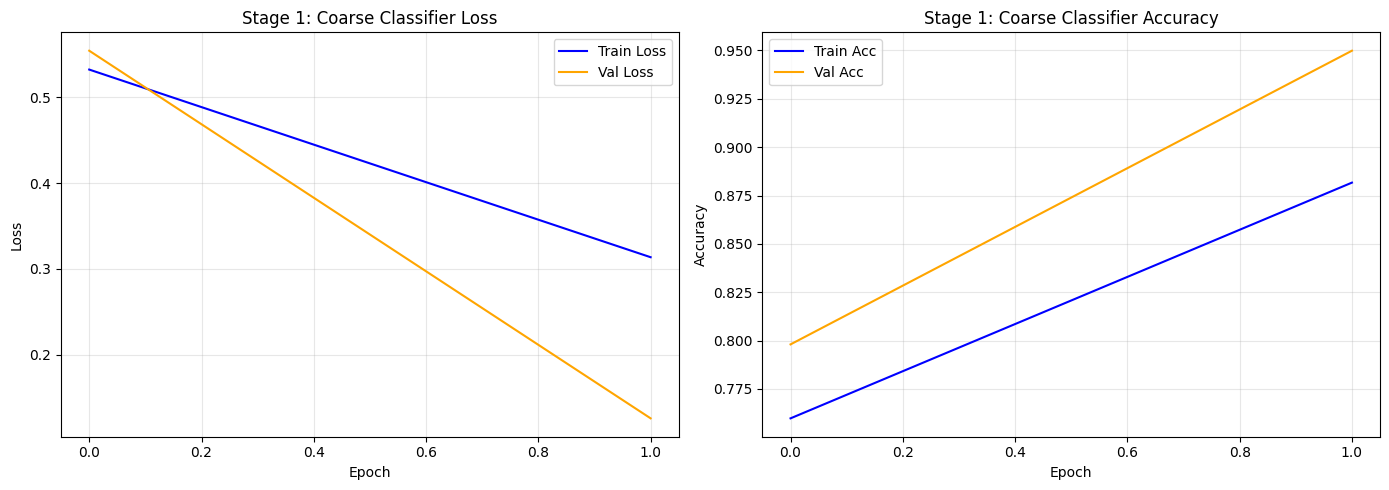

In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Stage 1: Coarse Classifier Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[1].plot(history['val_acc'], label='Val Acc', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Stage 1: Coarse Classifier Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PATHS['figures']}/stage1_coarse_training_{MODEL_CONFIG['architecture']}.png", dpi=150)
plt.show()

## 5. Evaluation on Test Set (Coarse Only)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load best model for evaluation
model.load_state_dict(torch.load(f"{PATHS['models']}/stage1_coarse_{MODEL_CONFIG['architecture']}.pth"))
model.eval()

# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, coarse_labels, _ in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(DEVICE, dtype=torch.float32)
        if imgs.max() > 1:
            imgs = imgs / 255.0
        coarse_labels = coarse_labels.long().to(DEVICE)
        
        coarse_logits = model.forward_coarse(imgs)
        preds = coarse_logits.argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(coarse_labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute metrics
test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("\n" + "="*60)
print("STAGE 1 TEST RESULTS")
print("="*60)
print(f"\n{'Metric':<15} {'Value':<10}")
print("-" * 25)
print(f"{'Accuracy':<15} {test_acc:.4f}")
print(f"{'Precision':<15} {test_precision:.4f}")
print(f"{'Recall':<15} {test_recall:.4f}")
print(f"{'F1-Score':<15} {test_f1:.4f}")
print(f"\nCorrectly classified {int(test_acc * len(all_labels))}/{len(all_labels)} samples")

C:\Users\BS-06\AppData\Local\Temp\ipykernel_15372\3421037134.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{PATHS['models']}/stage1_

KeyboardInterrupt: 

In [ ]:
# Per-region accuracy
from collections import defaultdict

region_correct = defaultdict(int)
region_total = defaultdict(int)

for pred, label in zip(all_preds, all_labels):
    region_name = region_idx_to_name[label]
    region_total[region_name] += 1
    if pred == label:
        region_correct[region_name] += 1

print("\nPer-Region Coarse Classification Accuracy:")
for region_name in region_idx_to_name.values():
    if region_total[region_name] > 0:
        acc = region_correct[region_name] / region_total[region_name]
        print(f"  {region_name}: {acc:.4f} ({region_correct[region_name]}/{region_total[region_name]})")


Per-Region Coarse Classification Accuracy:
  abdomen: 0.9451 (757/801)
  chest: 0.9178 (603/657)
  brain: 1.0000 (382/382)


## 6. Save Model Information for Stage 2

In [ ]:
# Save configuration for Stage 2 to use
import json

stage1_info = {
    'model_path': f"{PATHS['models']}/stage1_coarse_{MODEL_CONFIG['architecture']}.pth",
    'architecture': MODEL_CONFIG['architecture'],
    'coarse_architecture': MODEL_CONFIG['coarse_architecture'],
    'fine_architecture': MODEL_CONFIG['fine_architecture'],
    'dropout_rate': MODEL_CONFIG['dropout_rate'],
    'region_configs': region_configs,
    'region_idx_to_name': region_idx_to_name,
    'num_fine_classes': dataset_info['num_fine_classes'],
    'test_accuracy': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'best_val_accuracy': best_val_acc
}

with open(f"{PATHS['models']}/stage1_info_{MODEL_CONFIG['architecture']}.json", 'w') as f:
    json.dump(stage1_info, f, indent=2)

print(f"Stage 1 information saved to: {PATHS['models']}/stage1_info_{MODEL_CONFIG['architecture']}.json")
print("\nNow run 03b_stage2_fine_training.ipynb to train the fine classifiers.")

Stage 1 information saved to: /home/luca/HierarchicalMIC/models/stage1_info_enhanced.json

Now run 03b_stage2_fine_training.ipynb to train the fine classifiers.
